# HoneyBee Larvae Disease Classification using CNN through PyTorch

#### Building and training a Convolutional Neural Network (CNN) to classify images into one of four categories using PyTorch. We will use a dataset that contains images of honeybee larvae classified into four categories: Normal, Varroa Mite, Foulbrood, and Chalkbrood. 

#### This Jupyter Notebook comes with a detailed explantion of CNN, the functions used in the coding, the workflow and inferences in a separate pdf file.

### 1. Importing Required Libraries and Setting Up GPU

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import time

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### 2. Loading the Dataset and Exploring the Data

In [3]:
# Define data directories
train_dir = r'C:\Users\user\Documents\EcoUp\CNN Model\Training'
val_dir = r'C:\Users\user\Documents\EcoUp\CNN Model\Validation'

# Define the transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load training and validation datasets
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)


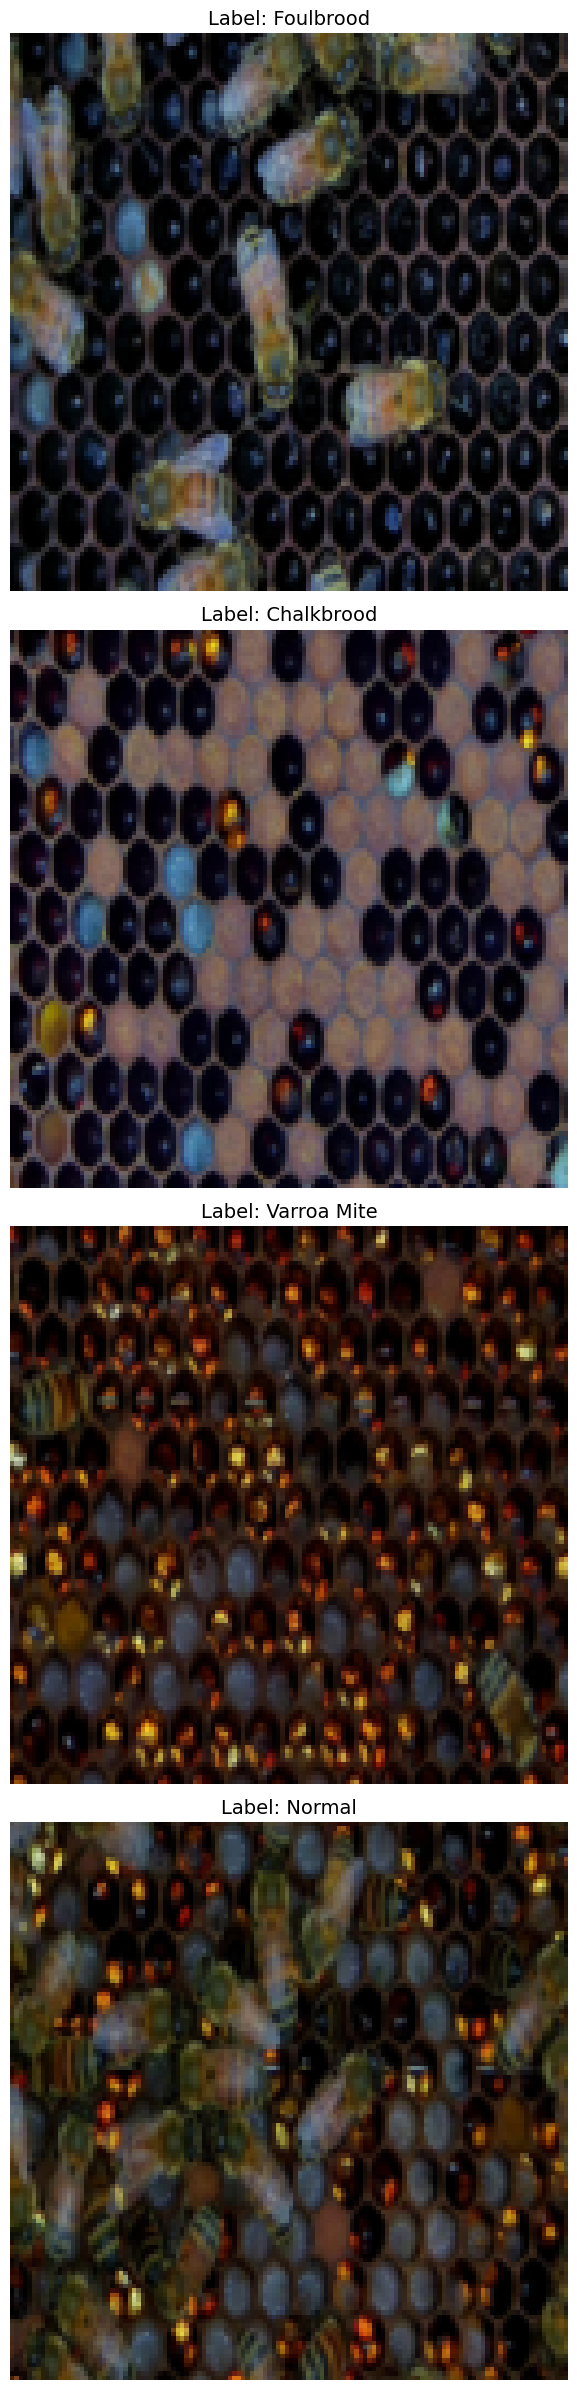

In [9]:
# Visualize one image from each category in the dataset

# Define a dictionary to map Korean labels to English labels

label_mapping = {
    '유충_정상': 'Normal',
    '유충_응애': 'Varroa Mite',
    '유충_부저병': 'Foulbrood',
    '유충_석고병': 'Chalkbrood'
}

def show_images_by_category(dataset, num_categories=4):
    plt.figure(figsize=(6, 24))  
    displayed_labels = []  # Track the categories we've already displayed

    for label_idx, (img, label) in enumerate(dataset):
        # Get the label name in English using the mapping
        korean_label = train_data.classes[label]  # Get the folder name (in Korean)
        english_label = label_mapping.get(korean_label, 'Unknown')  # Convert to English

        # If we haven't displayed this category yet, display it
        if english_label not in displayed_labels:
            img = img.permute(1, 2, 0)  # Change dimension for display (C, H, W -> H, W, C)
            
            plt.subplot(num_categories, 1, len(displayed_labels) + 1)
            plt.imshow(img)
            plt.title(f"Label: {english_label}", fontsize=14)  # Set title and font size
            plt.axis('off')  # Hide axis ticks
            
          
            displayed_labels.append(english_label)
        
        # Stop once we've displayed one image per category
        if len(displayed_labels) == num_categories:
            break

    plt.tight_layout() 
    plt.show()


show_images_by_category(train_data, num_categories=4)


### 3. Defining the CNN Model Architecture

In [10]:
# Define the CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Convolutional layer
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # Convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 4)  # Output layer for 4 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply ReLU and pooling after conv1
        x = self.pool(torch.relu(self.conv2(x)))  # Apply ReLU and pooling after conv2
        x = self.pool(torch.relu(self.conv3(x)))  # Apply ReLU and pooling after conv3
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor for fully connected layer
        x = torch.relu(self.fc1(x))  # Apply ReLU after first fully connected layer
        x = self.fc2(x)  # Output layer
        return x

# Instantiate the model and move it to GPU if available
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


### 4. Defining the Loss Function and Optimizer

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

### 5. Training the CNN Model

In [12]:
# Function to evaluate the model on validation data

def validate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()  # Use same loss function for validation

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute validation loss
            running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%, Validation Loss: {running_loss/len(val_loader):.4f}')


In [13]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model weights
            
            running_loss += loss.item()

        # Print average loss for the epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

        # Evaluate on validation data at the end of each epoch
        validate_model(model, val_loader)

    print('Training Complete.')

In [19]:
# Start training the model
start_time = time.time()
train_model(model, train_loader, criterion, optimizer, epochs=5)
end_time = time.time()
print(f"Training took: {end_time - start_time:.2f} seconds")

Epoch 1/5, Loss: 0.6172870021343231
Validation Accuracy: 70.25%, Validation Loss: 0.6026
Epoch 2/5, Loss: 0.5639174659252166
Validation Accuracy: 70.05%, Validation Loss: 0.5804
Epoch 3/5, Loss: 0.446367289853096
Validation Accuracy: 83.35%, Validation Loss: 0.3728
Epoch 4/5, Loss: 0.2313143903493881
Validation Accuracy: 84.70%, Validation Loss: 0.3735
Epoch 5/5, Loss: 0.14951744801700115
Validation Accuracy: 83.90%, Validation Loss: 0.4426
Training Complete.
Training took: 3685.45 seconds


##### As we see from the output that, Training Loss has decreased significantly from 0.617 (Epoch 1) to 0.149 (Epoch 5), which indicates the model is learning and improving its performance on the training data and Validation Accuracy improved from 70.25% (Epoch 1) to 84.70% (Epoch 4), but then slightly dipped to 83.90% (Epoch 5). This slight drop may indicate that the model is starting to overfit the training data. Also Validation Loss dropped initially from 0.6026 to 0.3728 but increased to 0.4426 in the final epoch, which is another potential sign of overfitting.To avoid overfitting, we will try add droput layer and early stopping.

### 6. Training the model again with Dropout layer and Early Stopping

In [4]:
# Define the CNN model with Dropout
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 output classes
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(torch.relu(self.fc1(x)))  # Apply dropout after first fully connected layer
        x = self.fc2(x)
        return x

In [5]:
# Function to save the model checkpoint
def save_checkpoint(model, optimizer, epoch, checkpoint_dir="checkpoints"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [6]:
# Function to load a saved checkpoint
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {checkpoint_path}, resuming from epoch {epoch}")
    return epoch

In [9]:
# Function to validate the model
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_loss = running_loss / len(val_loader)
    print(f'Validation Accuracy: {accuracy:.2f}%, Validation Loss: {val_loss:.4f}')
    return val_loss

In [10]:
# Early stopping function with epochs and patience
def early_stopping(model, train_loader, val_loader, patience, criterion, optimizer, epochs=10, checkpoint_dir="checkpoints"):
    best_loss = float('inf')
    epochs_without_improvement = 0
    best_model = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

        # Validation and early stopping
        val_loss = validate_model(model, val_loader)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping...")
                model.load_state_dict(best_model)  # Restore the best model
                break

        # Save a checkpoint after each epoch
        save_checkpoint(model, optimizer, epoch + 1, checkpoint_dir=checkpoint_dir)

    end_time = time.time()
    print(f'Training complete. Total time taken: {end_time - start_time:.2f} seconds.')

In [11]:
# Set device, optimizer, and criterion
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model with early stopping and checkpoint saving
early_stopping(model, train_loader, val_loader, patience=2, criterion=criterion, optimizer=optimizer, epochs=20)

Epoch 1/20, Loss: 0.7941356125831605
Validation Accuracy: 65.20%, Validation Loss: 0.6886
Checkpoint saved at checkpoints\checkpoint_epoch_1.pth
Epoch 2/20, Loss: 0.6615805674552917
Validation Accuracy: 65.60%, Validation Loss: 0.6655
Checkpoint saved at checkpoints\checkpoint_epoch_2.pth
Epoch 3/20, Loss: 0.6055464936256408
Validation Accuracy: 69.15%, Validation Loss: 0.6050
Checkpoint saved at checkpoints\checkpoint_epoch_3.pth
Epoch 4/20, Loss: 0.4500315449953079
Validation Accuracy: 83.80%, Validation Loss: 0.3563
Checkpoint saved at checkpoints\checkpoint_epoch_4.pth
Epoch 5/20, Loss: 0.30005540529489516
Validation Accuracy: 81.55%, Validation Loss: 0.3713
Checkpoint saved at checkpoints\checkpoint_epoch_5.pth
Epoch 6/20, Loss: 0.2564780196428299
Validation Accuracy: 84.35%, Validation Loss: 0.3451
Checkpoint saved at checkpoints\checkpoint_epoch_6.pth
Epoch 7/20, Loss: 0.2263188934713602
Validation Accuracy: 84.45%, Validation Loss: 0.3273
Checkpoint saved at checkpoints\checkpo

In [ ]:
#loading the checkpoint
#start_epoch = load_checkpoint('checkpoints/checkpoint_epoch_5.pth', model, optimizer)


### 7. Saving the Model

In [12]:
#Load the model’s state from the saved checkpoint of the best epoch
best_model_checkpoint = torch.load('checkpoints/checkpoint_epoch_7.pth')
model.load_state_dict(best_model_checkpoint['model_state_dict'])

C:\Users\user\AppData\Local\Temp\ipykernel_15896\1266496401.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_checkpoint = torch.load('checkpoints/checkpoint_ep

<All keys matched successfully>

In [13]:
torch.save(model.state_dict(), 'larvaeclassifyCNN_model.pth')

### 8. Testing the Model

##### Since the labels are in Korean, we need to do deal with it first

In [14]:
# Define a dictionary to map Korean class names to English
class_name_mapping = {
    '유충_정상': 'Larva_Normal',
    '유충_응애': 'Larva_Varroa_Mite',
    '유충_부저병': 'Larva_Foulbrood',
    '유충_석고병': 'Larva_Chalkbrood'
}


In [15]:
#Load the Dataset and Apply the Mapping:

from torchvision import datasets, transforms

# Load validation data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

val_data = datasets.ImageFolder(root=val_dir, transform=transform)

# Manually apply class name mapping to replace Korean with English
val_data.classes = [class_name_mapping[cls] for cls in val_data.classes]

In [16]:
#Displaying the Image and English Labels:

import torch.nn.functional as F

# Function to load the best model
def load_best_model(model_path):
    model = CNN().to(device)  # Initialize the model architecture
    model.load_state_dict(torch.load(model_path))  # Load the saved model weights
    model.eval()  # Set the model to evaluation mode (no dropout, no training)
    return model

# Function to display image, prediction, and confidence scores with English labels
def show_image_prediction_with_confidence(img_tensor, label, model, class_names):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get probability distribution
        confidence, predicted = torch.max(probabilities, 1)
        
        # Get predicted class name and true class name in English
        predicted_class = class_names[predicted.item()]
        true_class = class_names[label]
        
        # Plot image
        img = img_tensor.squeeze().cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy for visualization
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class}, True: {true_class}\nConfidence: {confidence.item()*100:.2f}%')
        plt.axis('off')
        plt.show()

        # Display full probability distribution
        for i, prob in enumerate(probabilities[0]):
            print(f"{class_names[i]}: {prob.item()*100:.2f}%")

# Load the best model
best_model = load_best_model('larvaeclassifyCNN_model.pth')

# Apply the mapping and load validation data
val_data = datasets.ImageFolder(root=val_dir, transform=transform)
val_data.classes = [class_name_mapping[cls] for cls in val_data.classes]  # Apply the mapping

C:\Users\user\AppData\Local\Temp\ipykernel_15896\658775592.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load the save

#### Now we can pass random images(not from training dataset) and see if this model is making correction predictions or not.
#### Confidence Scores below shows the confidence level (probability) for the predicted class

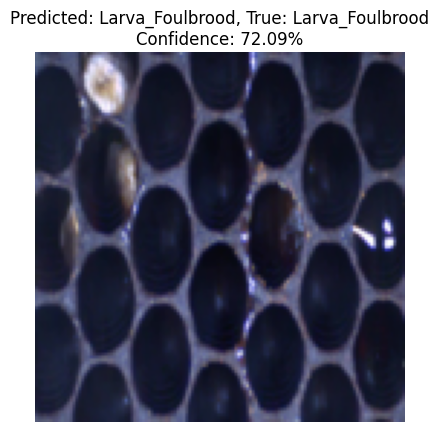

Larva_Foulbrood: 72.09%
Larva_Chalkbrood: 27.91%
Larva_Varroa_Mite: 0.00%
Larva_Normal: 0.00%


In [19]:
# Show an image from the validation set
img, label = val_data[60]  # Get an image and true label from the validation set
show_image_prediction_with_confidence(img, label, best_model, val_data.classes)

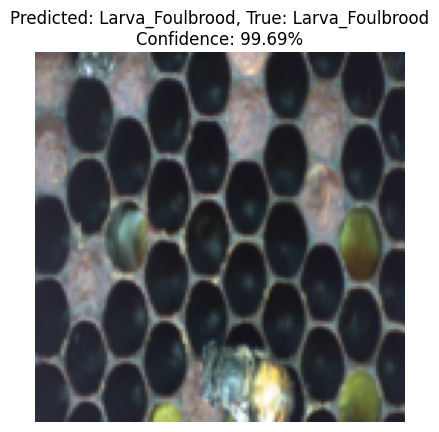

Larva_Foulbrood: 99.69%
Larva_Chalkbrood: 0.31%
Larva_Varroa_Mite: 0.00%
Larva_Normal: 0.00%


In [20]:
img, label = val_data[4]  # Get an image and true label from the validation set
show_image_prediction_with_confidence(img, label, best_model, val_data.classes)

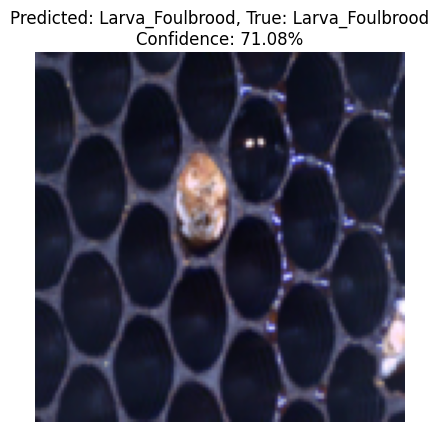

Larva_Foulbrood: 71.08%
Larva_Chalkbrood: 28.92%
Larva_Varroa_Mite: 0.00%
Larva_Normal: 0.00%


In [21]:
img, label = val_data[87]  # Get an image and true label from the validation set
show_image_prediction_with_confidence(img, label, best_model, val_data.classes)

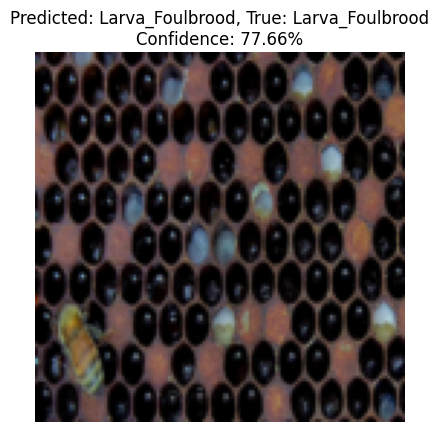

Larva_Foulbrood: 77.66%
Larva_Chalkbrood: 1.05%
Larva_Varroa_Mite: 0.00%
Larva_Normal: 21.30%


In [22]:
img, label = val_data[1]  # Get an image and true label from the validation set
show_image_prediction_with_confidence(img, label, best_model, val_data.classes)

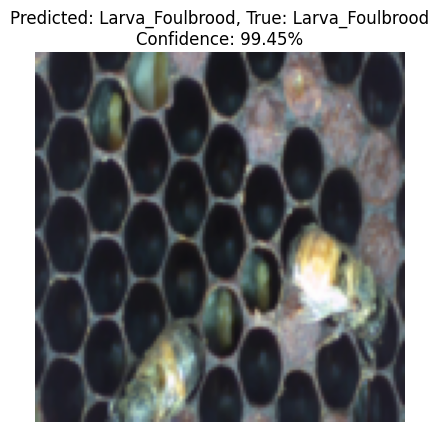

Larva_Foulbrood: 99.45%
Larva_Chalkbrood: 0.55%
Larva_Varroa_Mite: 0.00%
Larva_Normal: 0.00%


In [23]:
img, label = val_data[8]  # Get an image and true label from the validation set
show_image_prediction_with_confidence(img, label, best_model, val_data.classes)

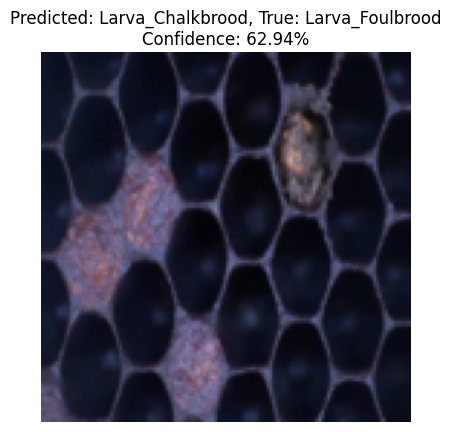

Larva_Foulbrood: 36.96%
Larva_Chalkbrood: 62.94%
Larva_Varroa_Mite: 0.04%
Larva_Normal: 0.06%


In [24]:
img, label = val_data[78]  # Get an image and true label from the validation set
show_image_prediction_with_confidence(img, label, best_model, val_data.classes)

# 9. Key Notes on the Trained Model:

#### 1. Model Structure:
##### The Convolutional Neural Network (CNN) model was built from scratch, with three convolutional layers followed by fully connected layers:
##### Convolutional Layers:
###### conv1: 32 filters, kernel size of 3x3, ReLU activation.
###### conv2: 64 filters, kernel size of 3x3, ReLU activation.
###### conv3: 128 filters, kernel size of 3x3, ReLU activation.
##### Pooling: Max-pooling applied after each convolutional layer to reduce the spatial dimensions by half.
##### Fully Connected Layers:
###### fc1: 256 neurons, followed by dropout with a 50% chance of deactivating neurons to prevent overfitting.
###### fc2: Final output layer with 4 neurons corresponding to the four classes (since this is a multi-class classification task).
#### 2. Training Process:
##### The model was trained for a maximum of 20 epochs, but early stopping was applied with patience set to 2 epochs. Training stopped after 9 epochs when the validation loss stopped improving.
##### The model was trained using the Adam optimizer with a learning rate of 0.001, and the loss function used was Cross-Entropy Loss.
#### 3. Model Performance:
##### Validation Accuracy: The best validation accuracy achieved during training was 84.45% at epoch 7.
##### Validation Loss: The lowest validation loss was 0.3273 at epoch 7.
##### Training Loss: By the end of training (epoch 9), the training loss had dropped to 0.1529.
##### Early Stopping: Early stopping was triggered due to an increase in validation loss after the 7th epoch, preventing overfitting.
#### 4. Model Evaluation:
##### The model was evaluated on a validation set consisting of 500 images spread across 4 classes (Larva_Normal, Larva_Varroa_Mite, Larva_Foulbrood, Larva_Chalkbrood).
##### Confusion between Classes: The model performed particularly well on normal larvae and varroa mite-infected larvae, though there were slight misclassifications in the more visually similar disease categories.
#### 5. Data and Training Details:
##### Training Set: The model was trained on 5,000 images from 4 different categories: Larva_Normal, Larva_Varroa_Mite, Larva_Foulbrood, and Larva_Chalkbrood.
##### Validation Set: Consisted of 500 images.
##### Image Preprocessing: Images were resized to 128x128 pixels and normalized.
#### 6. Model Applications:
##### This trained CNN model can be used to classify images of bee larvae into four categories based on their health status or disease condition.
##### The model can serve as a basis for teaching computer vision principles in biodiversity conservation, illustrating the practical application of deep learning in diagnosing bee diseases.
